In [39]:
import networkx as nx
from sklearn.linear_model import LogisticRegression
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import uuid
import itertools

In [160]:
class World:
    def __init__(self,  agents, init_edge_proba=0, agent_power=10):
        self.G=nx.Graph()
        
        for agent in agents:
            self.G.add_node(agent)
            
        for target in self.G.nodes:
            for other in self.G.nodes:
                if target != other and random.random() < init_edge_proba:
                    self.G.add_edge(target, other)
                    
        self.centrality_dict = nx.degree_centrality(self.G)
        self.history = pd.DataFrame()
        self.step = 0
        self.agent_power = agent_power 
        
    def draw(self):
        
        ndict = dict(zip(self.G.nodes, [str(i.name) for i in self.G.nodes]))
        fig = plt.figure(figsize = (10,10))
        pos=nx.spring_layout(self.G)
        nx.draw(self.G, pos = pos)
        nx.draw_networkx_labels(self.G, pos=pos, labels=ndict)
        plt.plot()
        
    def edge_evaluation(self, pred_a, pred_b):
        return (pred_a+pred_b)/2*random.uniform(0,2) > 0.5
        
        
    def utility_function(self, agent, other):
        is_connected = [agent, other] in self.G.edges
        
        if is_connected:
            return other.calculate_embeddedness()
        else:
            return 0
    
    def distribute_power(self, dictionary):
        distributed = [i*self.agent_power/sum(dictionary.values()) for i in dictionary.values()]
        return(dict(zip(dictionary.keys(), distributed)))
    
    def update_history(self, **kwargs):
        pass
        
    def iterate(self, iterations, verbose=0, draw=False):
        for iteration in range(iterations):
            for agent in self.G.nodes:
                agent.learn(self)
                agent.predict(self)
                agent.prediction_dict[self.step] = self.distribute_power(agent.prediction_dict[self.step])
                        
            for pair in itertools.combinations(self.G.nodes, 2):                
                if self.edge_evaluation(pair[0].prediction_dict[self.step][pair[1]],
                                        pair[1].prediction_dict[self.step][pair[0]]):
                    
                    if pair not in self.G.edges:
                        self.G.add_edge(*pair)
                        
                elif pair in self.G.edges:
                    self.G.remove_edge(*pair)
                
            if draw:
                self.draw()
                
            self.centrality_dict = nx.degree_centrality(self.G)
            self.step += 1

In [161]:
class AgentSkeleton:
    def __init__(self, name=None):
        self.prediction_dict = {}
        if name is None: 
            self.name = uuid.uuid1()
        else:
            self.name = name

    
    def learn(self, world):
        pass
    
    def predict(self, world):
        self.prediction_dict[world.step] = dict(zip(list(world.G.nodes), [random.random() for i in world.G.nodes]))
    
    def calculate_embeddedness(self, world):
        return world.centrality_dict[self]
        
    

In [170]:
class GetBasedOnDegree(AgentSkeleton):
    def predict(self, world):
        return world.centrality_dict

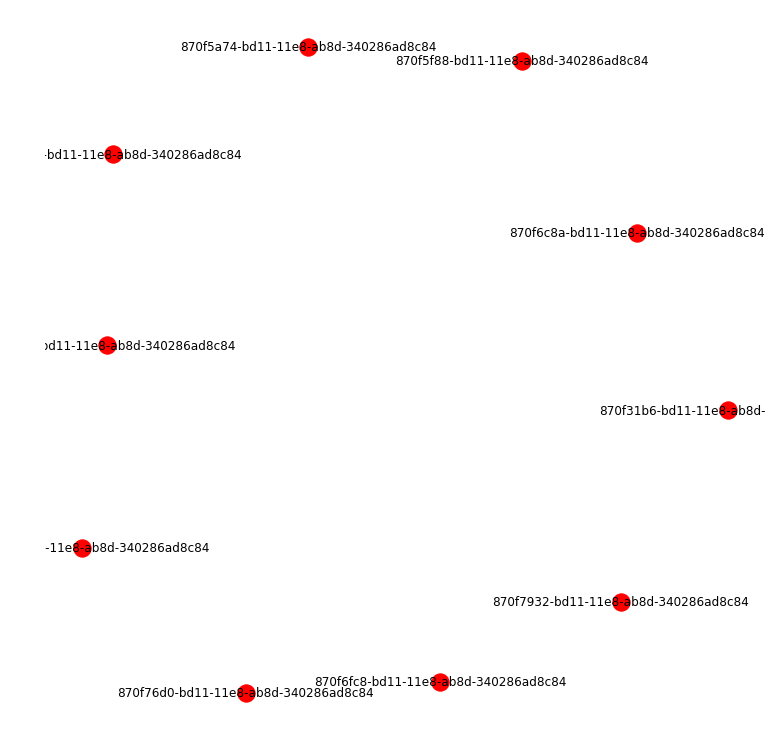

In [171]:
agents = [GetBasedOnDegree() for i in range(10)]
test_world = World(agents)
test_world.draw()

In [172]:
test_world.iterate(10, draw = True)

KeyError: 0

In [166]:
test_world.distribute_power({'a':1, 'b': 2, 'c':10000})

{'a': 0.000999700089973008, 'b': 0.001999400179946016, 'c': 9.99700089973008}

In [ ]:
test_world.agent_power